## 9.11 样式迁移

在本节中，我们将介绍如何使用卷积神经网络自动将某图像中的样式应用在另一图像之上，即样式迁移（style transfer）

In [1]:
%matplotlib inline
import os
import d2lzh as d2l
import numpy as np
import skimage.io
import skimage.transform
import tensorflow as tf
tf.enable_eager_execution()
from tensorflow import keras
import tensorflow.keras.backend as K
import time

### 9.11.2 读取内容图像和样式图像
首先，我们分别读取内容图像和样式图像。从打印出的图像坐标轴可以看出，它们的尺寸并不一样。

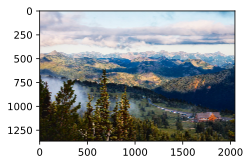

In [2]:
d2l.set_figsize()
content_img = skimage.io.imread('img/rainier.jpg')
d2l.plt.imshow(content_img);

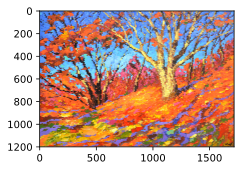

In [3]:
style_img = skimage.io.imread('img/autumn_oak.jpg')
d2l.plt.imshow(style_img);

### 9.11.3 预处理和后处理图像

下面定义图像的预处理函数和后处理函数。预处理函数preprocess对输入图像在RGB三个通道分别做标准化，并将结果变换成卷积神经网络接受的输入格式。后处理函数postprocess则将输出图像中的像素值还原回标准化之前的值。由于图像打印函数要求每个像素的浮点数值在0到1之间，我们使用clip函数对小于0和大于1的值分别取0和1。

In [4]:
rgb_mean = np.array([0.485, 0.456, 0.406])
rgb_std = np.array([0.229, 0.224, 0.225])

# img : 0 - 255, HWC
# ret : -1 - 1, NHWC
def preprocess(img, image_shape):
    img = skimage.transform.resize(img, image_shape) # 0-1:Float
    img = (img.astype('float32') - rgb_mean) / rgb_std
    return np.expand_dims(img, axis=0)

# img : -1 - 1, NHWC
def postprocess(img):
    img0 = img[0]
    return (img0 * rgb_std + rgb_mean).clip(0, 1)

### 9.11.4 抽取特征
我们使用基于ImageNet数据集预训练的VGG-19模型来抽取图像特征。

In [5]:
pretrained_net = keras.applications.vgg19.VGG19(weights='imagenet', include_top=False)
pretrained_net.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

为了抽取图像的内容特征和样式特征，我们可以选择VGG网络中某些层的输出。一般来说，越靠近输入层的输出越容易抽取图像的细节信息，反之则越容易抽取图像的全局信息。
为了避免合成图像过多保留内容图像的细节，我们选择VGG较靠近输出的层，也称内容层，来输出图像的内容特征。
我们还从VGG中选择不同层的输出来匹配局部和全局的样式，这些层也叫样式层。
在“使用重复元素的网络（VGG）”一节中我们曾介绍过，VGG网络使用了5个卷积块。实验中，我们选择第四卷积块的最后一个卷积层作为内容层，以及每个卷积块的第一个卷积层作为样式层。这些层的索引可以通过打印pretrained_net实例来获取。

In [6]:
net = keras.Model(
    inputs=pretrained_net.input, 
    outputs=[
        pretrained_net.get_layer('block4_conv4').output,    # Content Layer
        pretrained_net.get_layer('block1_conv1').output,    # Style Layer
        pretrained_net.get_layer('block2_conv1').output,    # Style Layer
        pretrained_net.get_layer('block3_conv1').output,    # Style Layer
        pretrained_net.get_layer('block5_conv1').output,    # Style Layer
    ])
for layer in net.layers:
   layer.trainable = False

In [7]:
def extract_features(X):
    cont, sty1, sty2, sty3, sty4 = net(tf.cast(X, tf.float32))
    contents = [cont]
    styles = [sty1, sty2, sty3, sty4]
    return contents, styles

In [8]:
def get_contents(image_shape):
    content_X = preprocess(content_img, image_shape)
    contents_Y, _ = extract_features(content_X)
    return content_X, contents_Y

def get_styles(image_shape):
    style_X = preprocess(style_img, image_shape)
    _, styles_Y = extract_features(style_X)
    return style_X, styles_Y

### 9.11.5 定义损失函数
下面我们来描述样式迁移的损失函数。它由内容损失、样式损失和总变差损失3部分组成。

#### 9.11.5.1 内容损失
与线性回归中的损失函数类似，内容损失通过平方误差函数衡量合成图像与内容图像在内容特征上的差异。平方误差函数的两个输入均为extract_features函数计算所得到的内容层的输出。

In [9]:
def content_loss(Y_hat, Y):
    return tf.reduce_mean(tf.square(Y_hat - Y))

#### 9.11.5.2 样式损失
样式损失也一样通过平方误差函数衡量合成图像与样式图像在样式上的差异。

In [10]:
def gram(X):
    num_channels, n = X.shape[3], tf.size(X) // X.shape[3]
    X = tf.reshape(X, (num_channels, n))
    return (X @ tf.transpose(X)) / tf.cast((num_channels * n), tf.float32)

def style_loss(Y_hat, gram_Y):
    return tf.reduce_mean(tf.square(gram(Y_hat) - gram_Y))

#### 9.11.5.3 总变差损失
有时候，我们学到的合成图像里面有大量高频噪点，即有特别亮或者特别暗的颗粒像素。一种常用的降噪方法是总变差降噪（total variation denoising）。假设 xi,j 表示坐标为 (i,j) 的像素值，降低总变差损失能够尽可能使邻近的像素值相似。

In [11]:
def tv_loss(Y_hat):
    # tensorflow 可以使用改函数直接计算 total variation loss
    # return 0.00001 * tf.reduce_mean(tf.image.total_variation(Y_hat))
    return 0.5 * (tf.reduce_mean(tf.abs(Y_hat[:, 1:, :, :] - Y_hat[:, :-1, :, :])) +
                  tf.reduce_mean(tf.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :])))

#### 9.11.5.4 损失函数
样式迁移的损失函数即内容损失、样式损失和总变差损失的加权和。通过调节这些权值超参数，我们可以权衡合成图像在保留内容、迁移样式以及降噪三方面的相对重要性。


In [12]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、样式损失和总变差损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = tf.add_n(styles_l) + tf.add_n(contents_l) + tv_l
    return contents_l, styles_l, tv_l, l

### 9.11.6 创建和初始化合成图像
在样式迁移中，合成图像是唯一需要更新的变量。因此，我们可以定义一个简单的模型GeneratedImage，并将合成图像视为模型参数。模型的前向计算只需返回模型参数即可。

In [13]:
class GeneratedImage(keras.Model):
    def __init__(self, img_shape):
        super(GeneratedImage, self).__init__()
        self.weight = self.add_weight(name='weight',
                                      shape=img_shape,
                                      initializer='uniform',
                                      trainable=True)
    def __call__(self, inputs=None):
        return self.weight


In [14]:
def get_inits(X, lr, styles_Y):
    gen_img = GeneratedImage(X.shape)
    gen_img.set_weights([X])
    trainer = keras.optimizers.Adam(learning_rate=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img, styles_Y_gram, trainer

### 9.11.7 训练

In [15]:
def train(X, contents_Y, styles_Y, lr, max_epochs, lr_decay_epoch):
    Xnet, styles_Y_gram, trainer = get_inits(X, lr, styles_Y)
    for i in range(max_epochs):
        start = time.time()
        with tf.GradientTape() as type:
            #type.watch(Xnet.trainable_variables)
            contents_Y_hat, styles_Y_hat = extract_features(Xnet())
            contents_l, styles_l, tv_l, l = compute_loss(
                Xnet(), contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        grads = type.gradient(l, Xnet.trainable_variables)
        trainer.apply_gradients(zip(grads, Xnet.trainable_variables))
    
        if i % 50 == 0 and i != 0:
            print('epoch %3d, total loss %.2f, content loss %.2f, style loss %.2f, TV loss %.2f, %.2f sec'
                  % (i, l, tf.add_n(contents_l),
                     tf.add_n(styles_l), tv_l,
                     time.time() - start))
        if i % lr_decay_epoch == 0 and i != 0:
            lr = K.get_value(trainer.learning_rate)
            K.set_value(trainer.learning_rate, lr * 0.1)
            print('change lr to %.1e' % K.get_value(trainer.learning_rate))
    return Xnet()

In [16]:
image_shape = (150, 225)
content_X, contents_Y = get_contents(image_shape)
_, styles_Y = get_styles(image_shape)
output = train(content_X, contents_Y, styles_Y, 0.01, 500, 200)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


epoch  50, total loss 8.81, content loss 1.37, style loss 4.14, TV loss 3.30, 0.03 sec
epoch 100, total loss 6.34, content loss 1.43, style loss 1.82, TV loss 3.09, 0.03 sec
epoch 150, total loss 5.51, content loss 1.29, style loss 1.38, TV loss 2.84, 0.03 sec
epoch 200, total loss 5.07, content loss 1.20, style loss 1.21, TV loss 2.67, 0.03 sec
change lr to 1.0e-03
epoch 250, total loss 5.03, content loss 1.19, style loss 1.20, TV loss 2.64, 0.03 sec
epoch 300, total loss 4.99, content loss 1.18, style loss 1.19, TV loss 2.63, 0.03 sec
epoch 350, total loss 4.95, content loss 1.17, style loss 1.18, TV loss 2.61, 0.03 sec
epoch 400, total loss 4.92, content loss 1.16, style loss 1.16, TV loss 2.59, 0.03 sec
change lr to 1.0e-04
epoch 450, total loss 4.91, content loss 1.16, style loss 1.16, TV loss 2.59, 0.03 sec


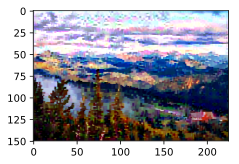

In [17]:
d2l.plt.imshow(postprocess(output.numpy()))

为了得到更加清晰的合成图像，下面我们在更大的 300×450 尺寸上训练。我们将图9.14的高和宽放大2倍，以初始化更大尺寸的合成图像。

In [18]:
image_shape = (300, 450)
content_X, contents_Y = get_contents(image_shape)
_, styles_Y = get_styles(image_shape)
output = train(content_X, contents_Y, styles_Y, 0.01, 300, 100)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


epoch  50, total loss 8.43, content loss 1.51, style loss 4.02, TV loss 2.89, 0.04 sec
epoch 100, total loss 5.47, content loss 1.59, style loss 1.07, TV loss 2.81, 0.04 sec
change lr to 1.0e-03
epoch 150, total loss 5.31, content loss 1.56, style loss 0.99, TV loss 2.76, 0.04 sec
epoch 200, total loss 5.19, content loss 1.53, style loss 0.93, TV loss 2.72, 0.04 sec
change lr to 1.0e-04
epoch 250, total loss 5.17, content loss 1.53, style loss 0.92, TV loss 2.72, 0.04 sec


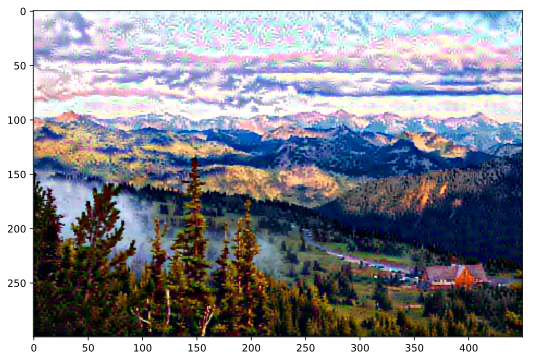

In [19]:
d2l.plt.figure(figsize=(9,6))
d2l.plt.imshow(postprocess(output.numpy()))